In [1]:
import os

import numpy as np
from keras.layers import RepeatVector
from keras.layers.core import Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.models import load_model

np.random.seed(123)


def prepare_sequences(x_train, window_length, random_indices):
    full_sequence = x_train.flatten()
    windows = []
    outliers = []
    for window_start in range(0, len(full_sequence) - window_length + 1):
        window_end = window_start + window_length
        window_range = range(window_start, window_end)
        window = list(full_sequence[window_range])
        contain_outlier = len(set(window_range).intersection(set(random_indices))) > 0
        outliers.append(contain_outlier)
        windows.append(window)
    return np.expand_dims(np.array(windows), axis=2), outliers


def get_signal(size, outliers_size=0.01):
    sig = np.expand_dims(np.random.normal(loc=0, scale=1, size=(size, 1)), axis=1)
    if outliers_size < 1:  # percentage.
        outliers_size = int(size * outliers_size)
    random_indices = np.random.choice(range(size), size=outliers_size, replace=False)
    sig[random_indices] = np.random.randint(6, 9, 1)[0]
    return sig, random_indices


def tp_fn_fp_tn(total, expected, actual):
    tp = len(set(expected).intersection(set(actual)))
    fn = len(set(expected) - set(actual))
    fp = len(set(actual) - set(expected))
    tn = len((total - set(expected)).intersection(total - set(actual)))
    return tp, fn, fp, tn



window_length = 10
hidden_dim = 16

# no outliers.
signal_train, _ = get_signal(100000, outliers_size=0)
x_train, _ = prepare_sequences(signal_train, window_length, [])

# 1 percent are outliers.
signal_test, random_indices = get_signal(100000, outliers_size=0.01)
x_test, contain_outliers = prepare_sequences(signal_test, window_length, random_indices)
outlier_indices = np.where(contain_outliers)[0]

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
m = Sequential()
m.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=True))
m.add(Dropout(p=0.1))
m.add(LSTM(1, return_sequences=True, activation='linear'))
m.compile(loss='mse', optimizer='adam')
m.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 47s 471us/step - loss: 0.1159 - val_loss: 0.2164
Epoch 2/5
99991/99991 [==============================] - 47s 468us/step - loss: 0.0154 - val_loss: 0.1935
Epoch 3/5
99991/99991 [==============================] - 44s 439us/step - loss: 0.0116 - val_loss: 0.1664
Epoch 4/5
99991/99991 [==============================] - 45s 446us/step - loss: 0.0098 - val_loss: 0.1344
Epoch 5/5
99991/99991 [==============================] - 44s 438us/step - loss: 0.0088 - val_loss: 0.1117


In [3]:
m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 16)            1152      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


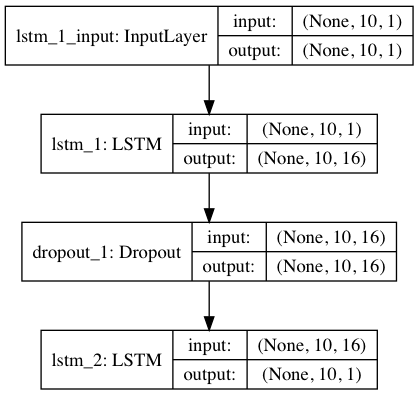

In [4]:
from keras.utils import plot_model
fname = 'time_series_all_mtom.png'
plot_model(m,to_file=fname, show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename=fname)

In [5]:
pred_x_test = m.predict(x_test)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


(9465, 0, 0, 90526)

In [6]:
# select_only_last_state
m_last = Sequential()
m_last.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
m_last.add(RepeatVector(window_length))
m_last.add(Dropout(p=0.1))
m_last.add(LSTM(1, return_sequences=True, activation='linear'))
m_last.compile(loss='mse', optimizer='adam')
m_last.fit(x_train, x_train, batch_size=64, nb_epoch=5, validation_data=(x_test, x_test))


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  """
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/5
99991/99991 [==============================] - 46s 465us/step - loss: 0.8889 - val_loss: 1.4160
Epoch 2/5
99991/99991 [==============================] - 44s 445us/step - loss: 0.8711 - val_loss: 1.4061
Epoch 3/5
99991/99991 [==============================] - 46s 461us/step - loss: 0.8684 - val_loss: 1.4067
Epoch 4/5
99991/99991 [==============================] - 43s 434us/step - loss: 0.8659 - val_loss: 1.4027
Epoch 5/5
99991/99991 [==============================] - 44s 440us/step - loss: 0.8635 - val_loss: 1.4132


In [7]:
m_last.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1152      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 16)            0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 16)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 1)             72        
Total params: 1,224
Trainable params: 1,224
Non-trainable params: 0
_________________________________________________________________


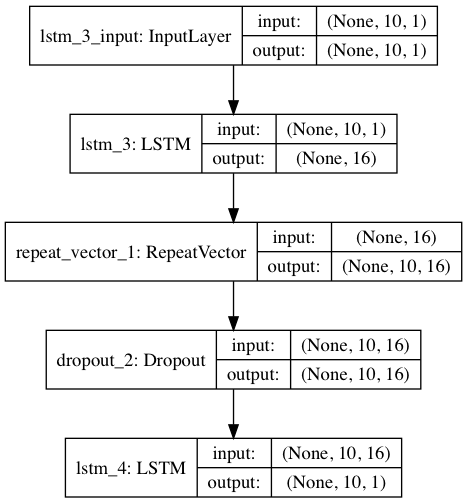

In [8]:
from keras.utils import plot_model
fname = 'time_series_last_st.png'
plot_model(m_last,to_file=fname, show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(filename=fname)

In [9]:
pred_x_test = m_last.predict(x_test)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 1.0, hit_rate = 0.9997886951928157, accuracy = 0.999979998199838


(9463, 2, 0, 90526)

In [10]:
# select_only_last_state
m_last = Sequential()
m_last.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
m_last.add(RepeatVector(window_length))
m_last.add(Dropout(p=0.1))
m_last.add(LSTM(1, return_sequences=True, activation='linear'))
m_last.compile(loss='mse', optimizer='adam')
m_last.fit(x_train, x_train, batch_size=64, nb_epoch=100, validation_data=(x_test, x_test))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  """
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/100
99991/99991 [==============================] - 46s 455us/step - loss: 0.8927 - val_loss: 1.4185
Epoch 2/100
99991/99991 [==============================] - 43s 434us/step - loss: 0.8702 - val_loss: 1.4040
Epoch 3/100
99991/99991 [==============================] - 45s 453us/step - loss: 0.8660 - val_loss: 1.4050
Epoch 4/100
99991/99991 [==============================] - 43s 432us/step - loss: 0.8628 - val_loss: 1.4052
Epoch 5/100
99991/99991 [==============================] - 42s 422us/step - loss: 0.8601 - val_loss: 1.4024
Epoch 6/100
99991/99991 [==============================] - 43s 427us/step - loss: 0.8572 - val_loss: 1.4026
Epoch 7/100
99991/99991 [==============================] - 50s 504us/step - loss: 0.8541 - val_loss: 1.4014
Epoch 8/100
99991/99991 [==============================] - 48s 479us/step - loss: 0.8517 - val_loss: 1.4076
Epoch 9/100
99991/99991 [==============================] - 51s 507us/step - loss: 0.84

Epoch 76/100
99991/99991 [==============================] - 43s 428us/step - loss: 0.8353 - val_loss: 1.3658
Epoch 77/100
99991/99991 [==============================] - 43s 431us/step - loss: 0.8293 - val_loss: 1.3516
Epoch 78/100
99991/99991 [==============================] - 43s 428us/step - loss: 0.8353 - val_loss: 1.3858
Epoch 79/100
99991/99991 [==============================] - 43s 428us/step - loss: 0.8369 - val_loss: 1.3699
Epoch 80/100
99991/99991 [==============================] - 43s 428us/step - loss: 0.8301 - val_loss: 1.3559
Epoch 81/100
99991/99991 [==============================] - 43s 429us/step - loss: 0.8284 - val_loss: 1.3506
Epoch 82/100
99991/99991 [==============================] - 43s 429us/step - loss: 0.8286 - val_loss: 1.3567
Epoch 83/100
99991/99991 [==============================] - 46s 460us/step - loss: 0.8305 - val_loss: 1.3590
Epoch 84/100
99991/99991 [==============================] - 44s 437us/step - loss: 0.8334 - val_loss: 1.3765
Epoch 85/100
99991/

In [11]:
pred_x_test = m_last.predict(x_test)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 1.0, hit_rate = 1.0, accuracy = 1.0


(9465, 0, 0, 90526)

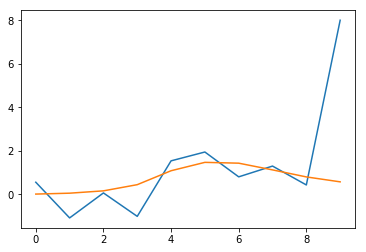

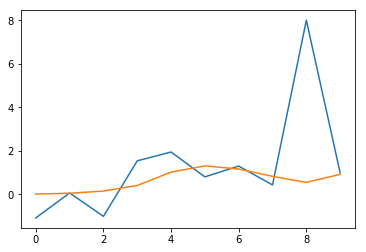

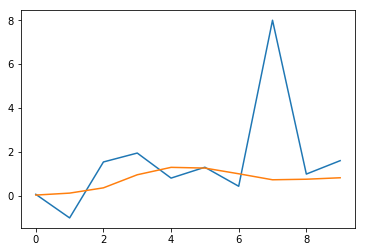

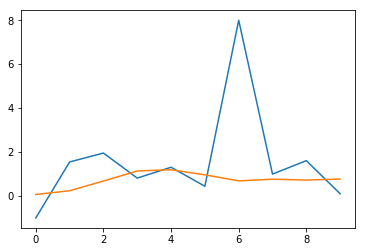

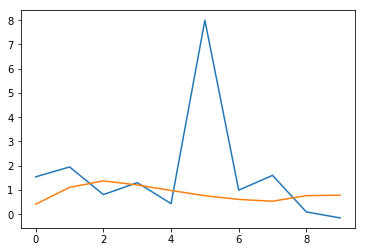

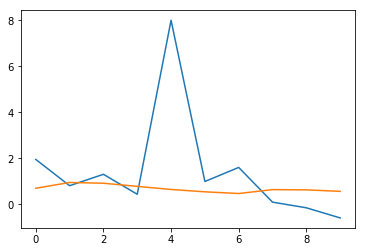

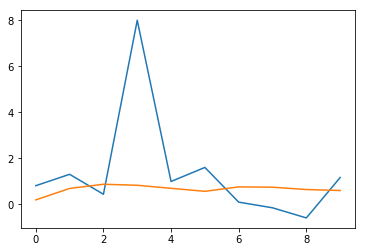

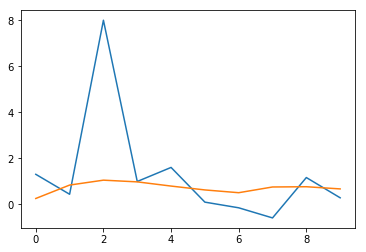

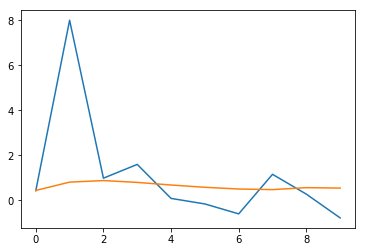

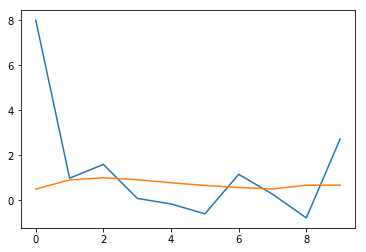

In [13]:
import matplotlib.pyplot as plt
for index in outlier_indices[0:10]:
    plt.plot(x_test[index])
    plt.plot(pred_x_test[index])
    plt.show()

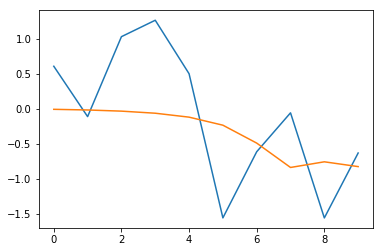

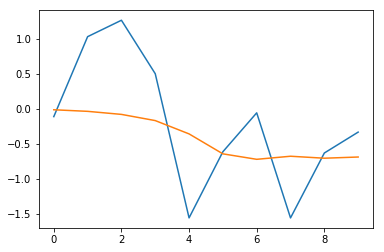

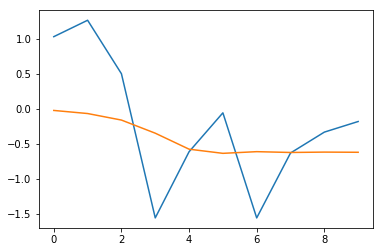

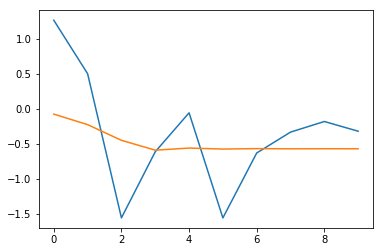

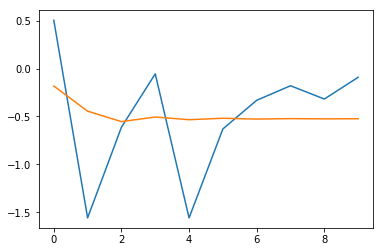

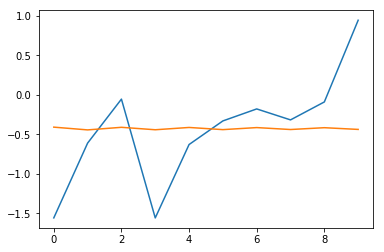

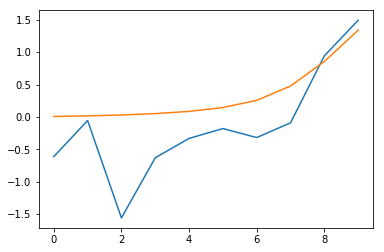

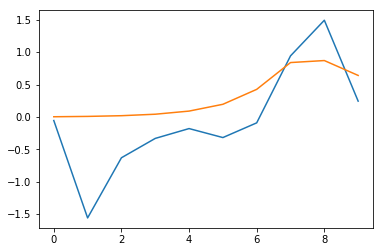

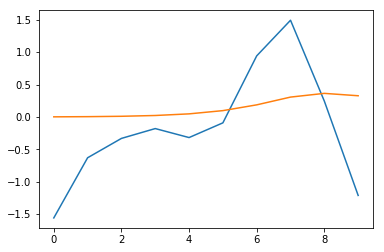

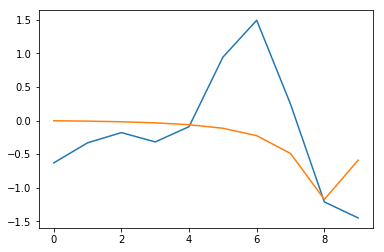

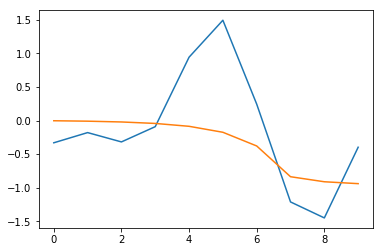

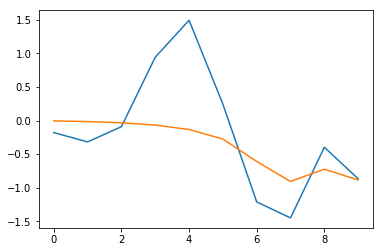

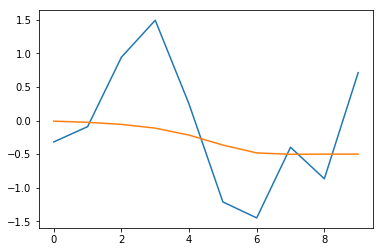

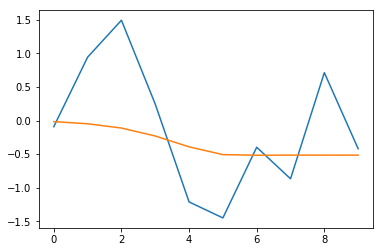

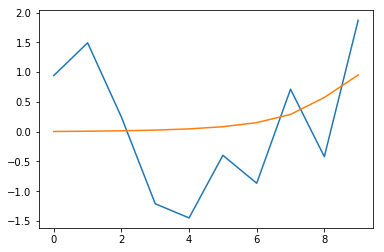

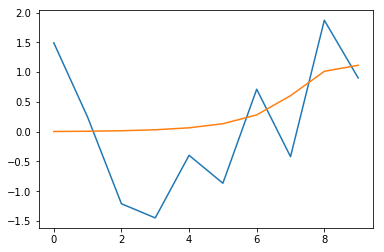

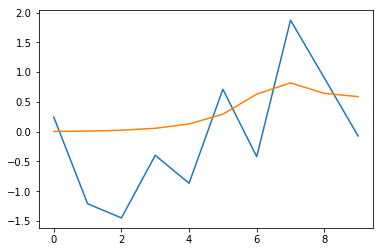

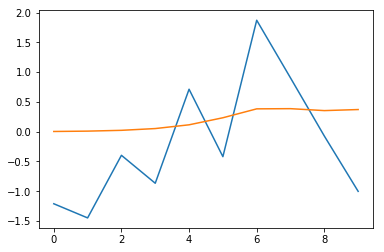

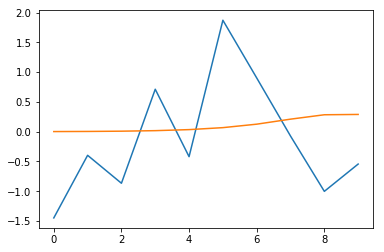

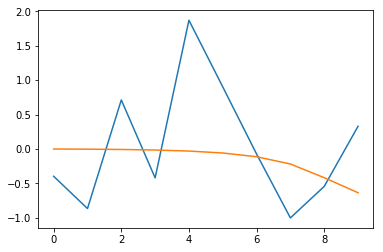

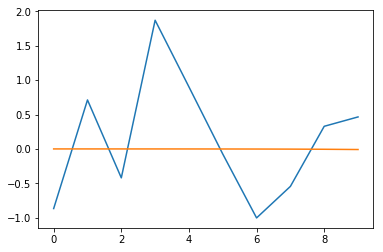

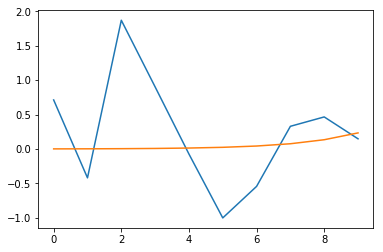

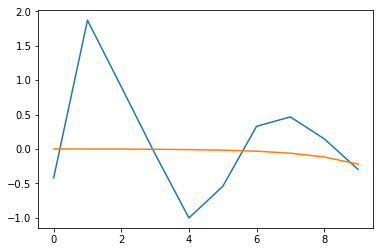

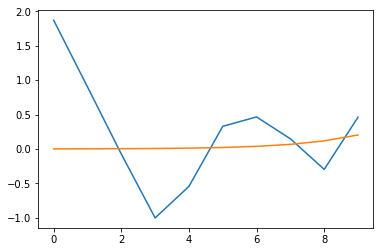

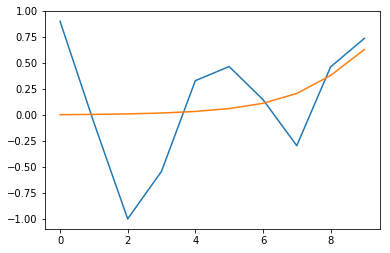

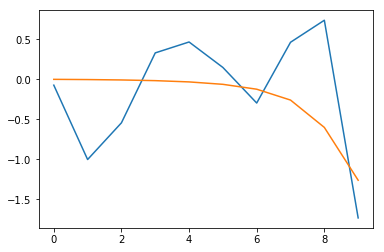

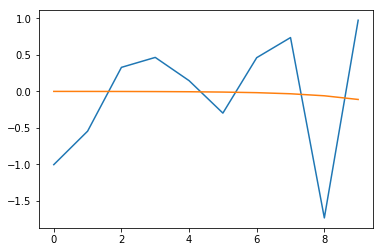

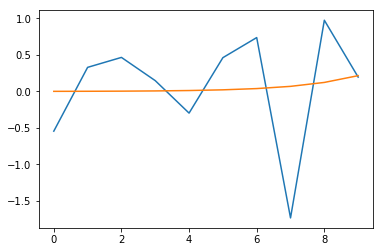

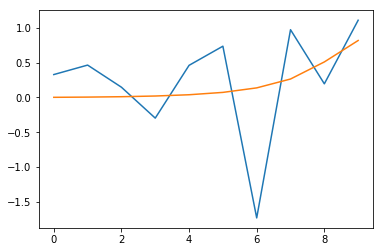

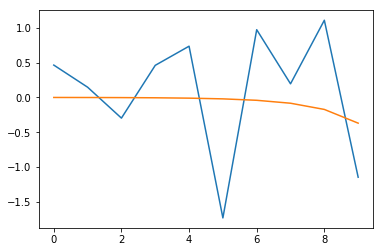

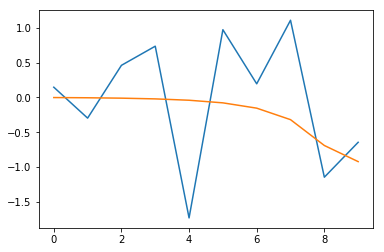

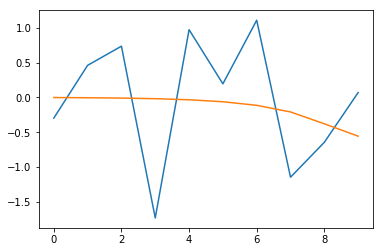

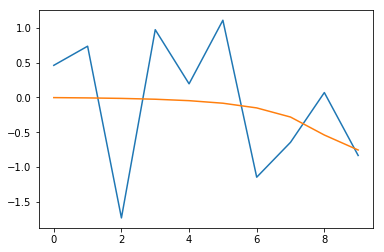

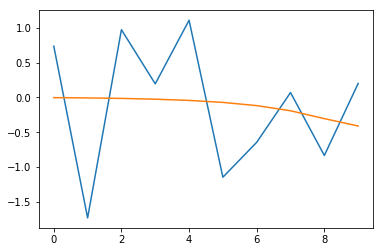

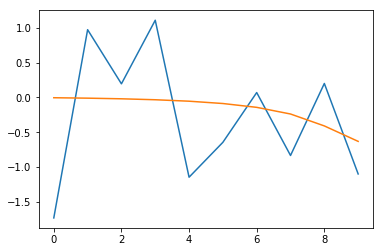

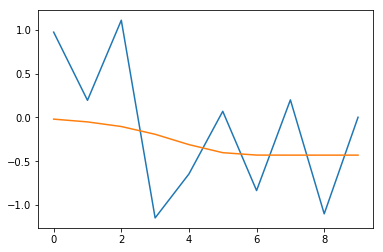

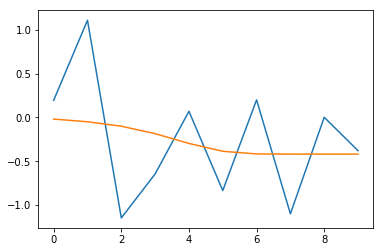

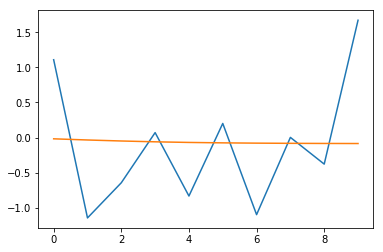

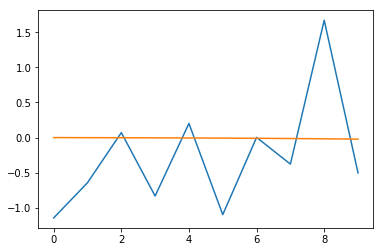

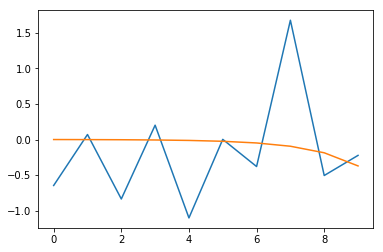

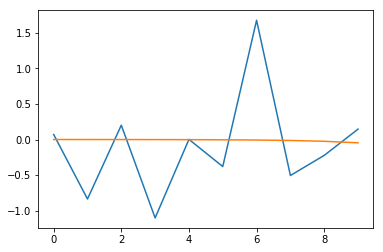

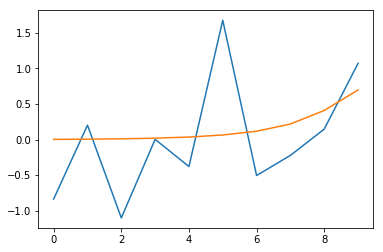

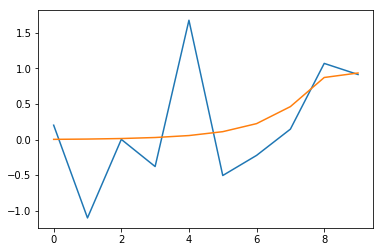

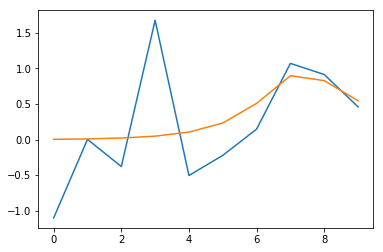

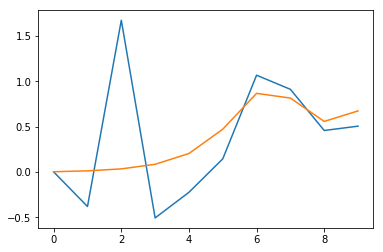

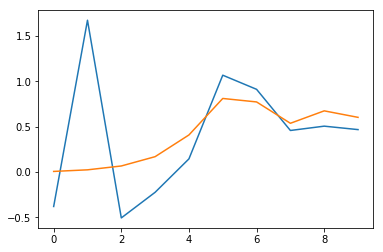

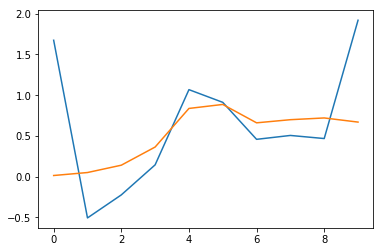

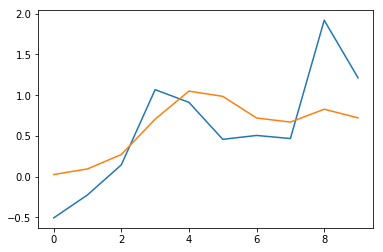

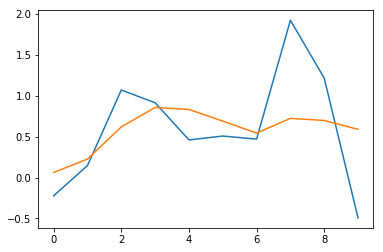

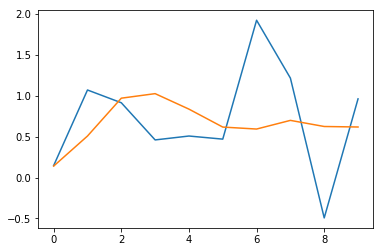

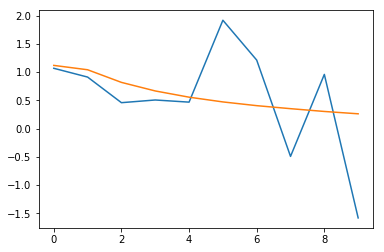

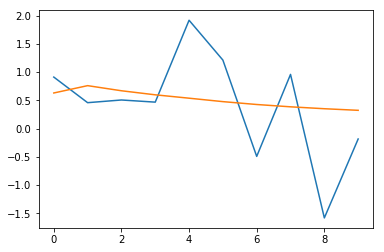

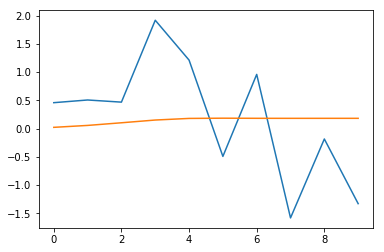

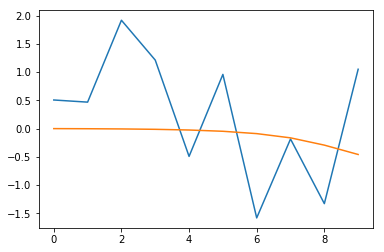

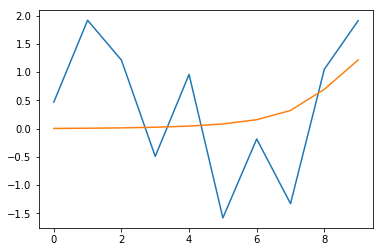

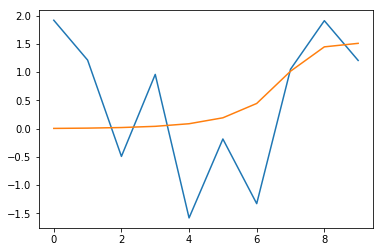

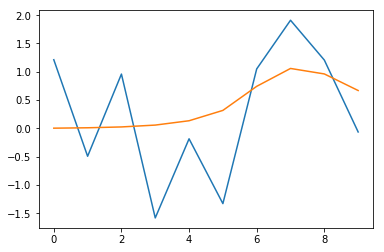

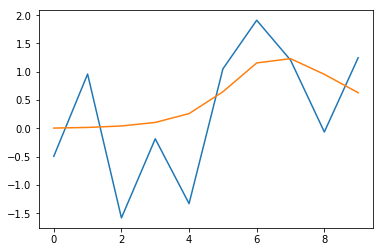

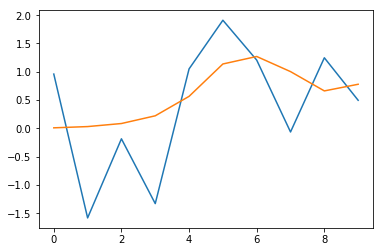

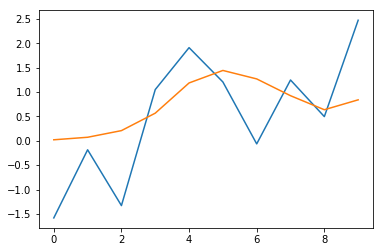

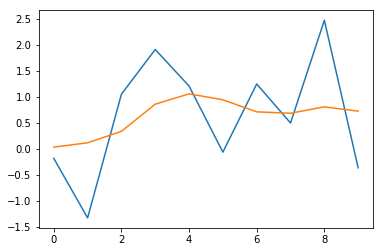

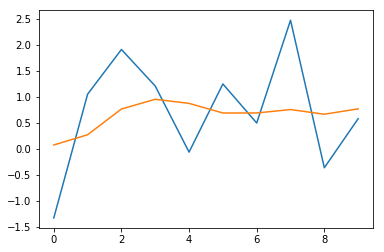

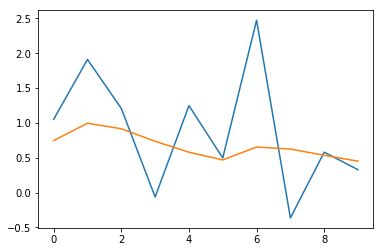

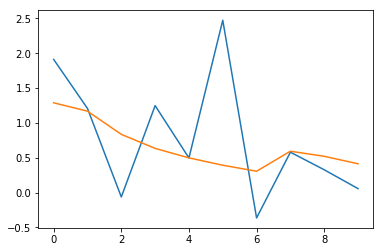

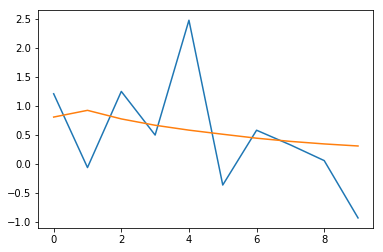

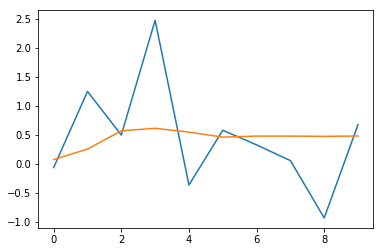

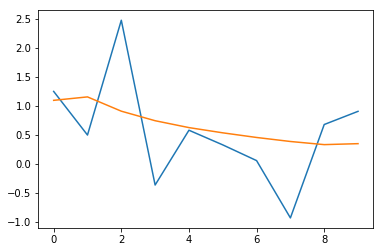

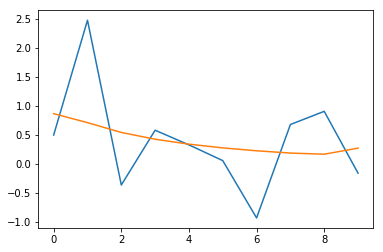

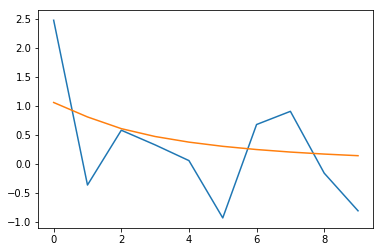

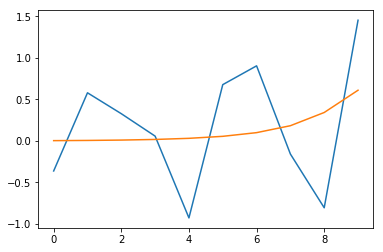

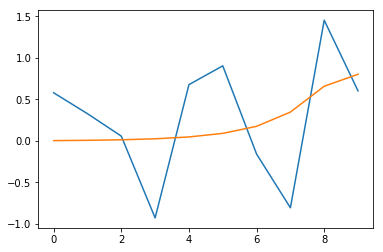

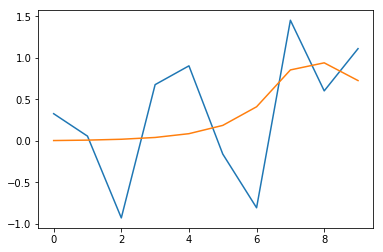

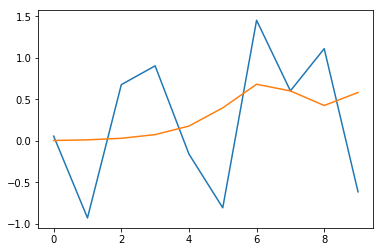

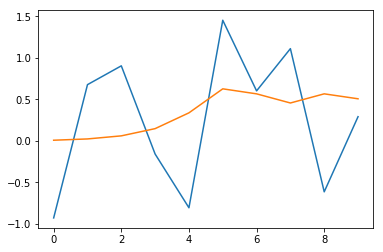

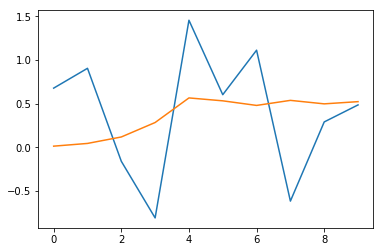

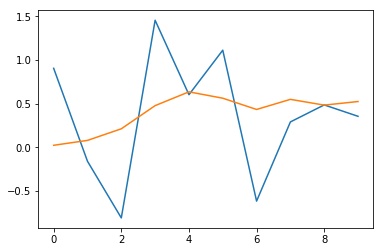

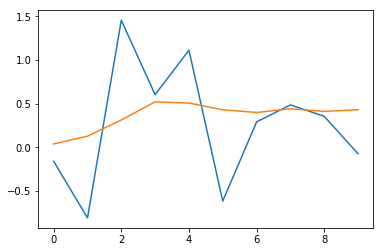

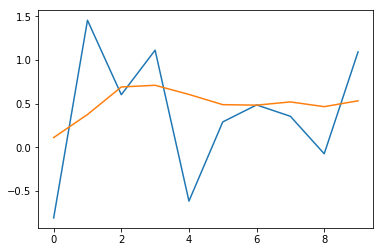

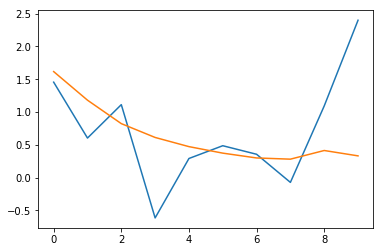

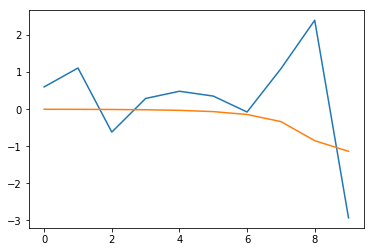

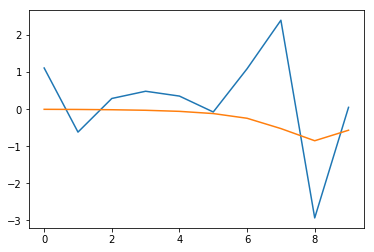

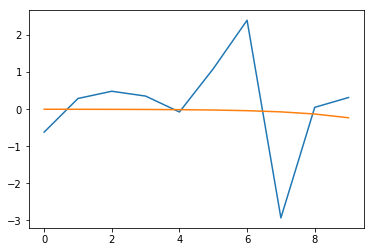

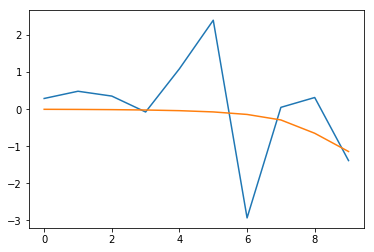

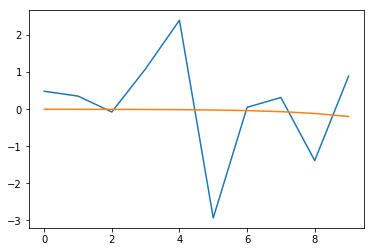

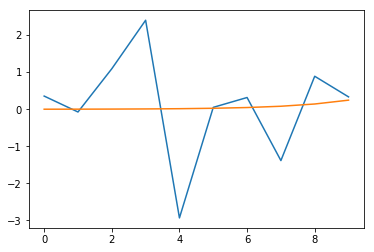

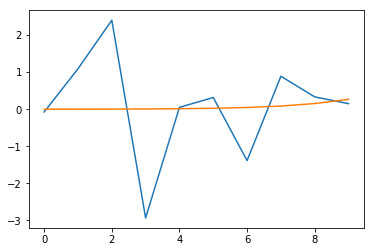

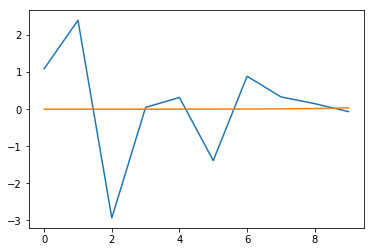

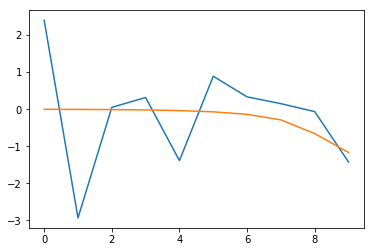

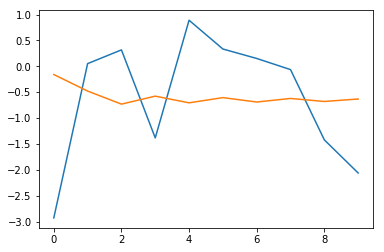

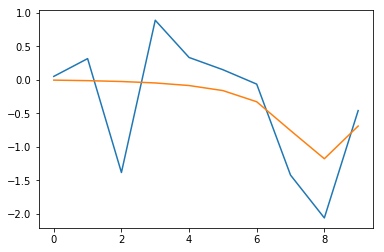

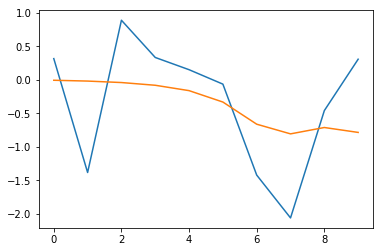

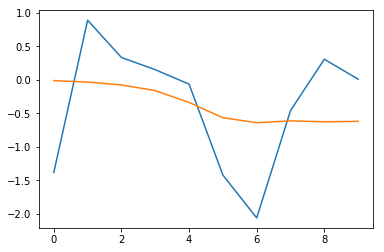

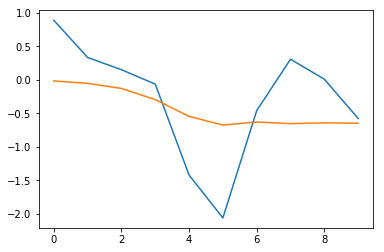

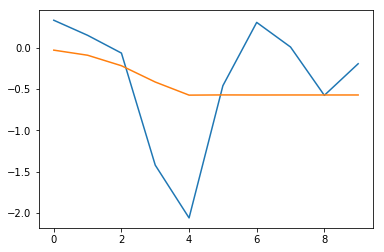

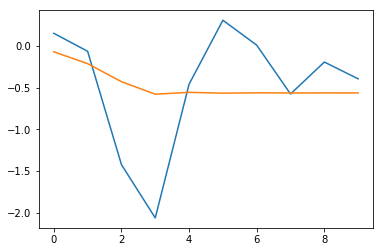

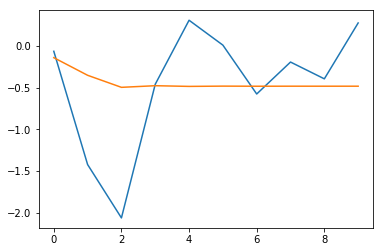

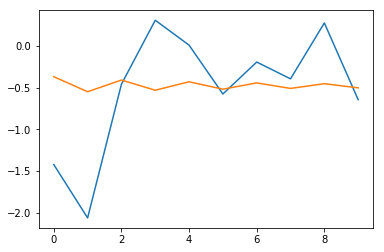

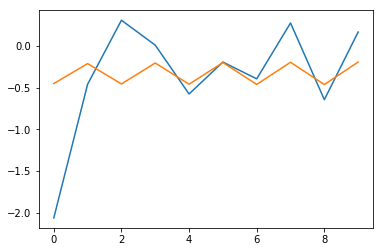

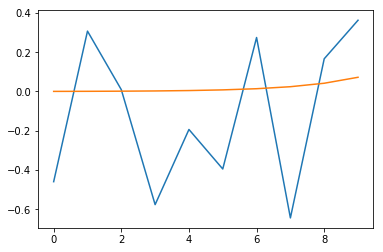

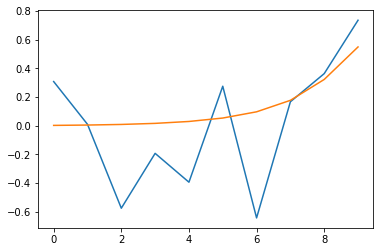

In [14]:
import matplotlib.pyplot as plt
for index in range(0,100):
    plt.plot(x_test[index])
    plt.plot(pred_x_test[index])
    plt.show()

In [15]:
x_train_rev = []
x_test_rev = []
for item in x_train:
    x_train_rev.append(item[::-1])
for item in x_test:
    x_test_rev.append(item[::-1])
x_train_rev = np.array(x_train_rev)
x_test_rev = np.array(x_test_rev)
x_train_rev.shape, x_test_rev.shape, x_test.shape

((99991, 10, 1), (99991, 10, 1), (99991, 10, 1))

In [16]:
x_train_rev[0], x_train[0]

(array([[-0.8667404 ],
        [ 1.26593626],
        [-0.42891263],
        [-2.42667924],
        [ 1.65143654],
        [-0.57860025],
        [-1.50629471],
        [ 0.2829785 ],
        [ 0.99734545],
        [-1.0856306 ]]), array([[-1.0856306 ],
        [ 0.99734545],
        [ 0.2829785 ],
        [-1.50629471],
        [-0.57860025],
        [ 1.65143654],
        [-2.42667924],
        [-0.42891263],
        [ 1.26593626],
        [-0.8667404 ]]))

In [17]:
m_last_rev = Sequential()
m_last_rev.add(LSTM(hidden_dim, input_shape=(window_length, 1), return_sequences=False))
m_last_rev.add(RepeatVector(window_length))
m_last_rev.add(Dropout(p=0.1))
m_last_rev.add(LSTM(1, return_sequences=True, activation='linear'))
m_last_rev.compile(loss='mse', optimizer='adam')
m_last_rev.fit(x_train, x_train_rev, batch_size=64, nb_epoch=100, validation_data=(x_test, x_test_rev))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(rate=0.1)`
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 99991 samples, validate on 99991 samples
Epoch 1/100
99991/99991 [==============================] - 45s 451us/step - loss: 0.8893 - val_loss: 1.4123
Epoch 2/100
99991/99991 [==============================] - 43s 426us/step - loss: 0.8664 - val_loss: 1.3976
Epoch 3/100
99991/99991 [==============================] - 43s 426us/step - loss: 0.8602 - val_loss: 1.3922
Epoch 4/100
99991/99991 [==============================] - 42s 424us/step - loss: 0.8545 - val_loss: 1.3868
Epoch 5/100
99991/99991 [==============================] - 42s 425us/step - loss: 0.8485 - val_loss: 1.3812
Epoch 6/100
99991/99991 [==============================] - 42s 422us/step - loss: 0.8447 - val_loss: 1.3767
Epoch 7/100
99991/99991 [==============================] - 42s 425us/step - loss: 0.8427 - val_loss: 1.3751
Epoch 8/100
99991/99991 [==============================] - 43s 426us/step - loss: 0.8403 - val_loss: 1.3702
Epoch 9/100
99991/99991 [==============================] - 43s 426us/step - loss: 0.83

Epoch 76/100
99991/99991 [==============================] - 41s 412us/step - loss: 0.8119 - val_loss: 1.2840
Epoch 77/100
99991/99991 [==============================] - 41s 412us/step - loss: 0.8104 - val_loss: 1.2935
Epoch 78/100
99991/99991 [==============================] - 41s 410us/step - loss: 0.8108 - val_loss: 1.2757
Epoch 79/100
99991/99991 [==============================] - 41s 410us/step - loss: 0.8116 - val_loss: 1.2701
Epoch 80/100
99991/99991 [==============================] - 41s 411us/step - loss: 0.8195 - val_loss: 1.2834
Epoch 81/100
99991/99991 [==============================] - 41s 411us/step - loss: 0.8108 - val_loss: 1.2796
Epoch 82/100
99991/99991 [==============================] - 41s 411us/step - loss: 0.8109 - val_loss: 1.2848
Epoch 83/100
99991/99991 [==============================] - 41s 412us/step - loss: 0.8103 - val_loss: 1.2772
Epoch 84/100
99991/99991 [==============================] - 41s 411us/step - loss: 0.8099 - val_loss: 1.2819
Epoch 85/100
99991/

In [19]:
pred_x_test = m_last_rev.predict(x_test_rev)
mae_of_predictions = np.squeeze(np.max(np.square(pred_x_test - x_test_rev), axis=1))
mae_threshold = np.mean(mae_of_predictions) + np.std(mae_of_predictions)  # can use a running mean instead.
actual = np.where(mae_of_predictions > mae_threshold)[0]

tp, fn, fp, tn = tp_fn_fp_tn(set(range(len(pred_x_test))), outlier_indices, actual)
precision = float(tp) / (tp + fp)
hit_rate = float(tp) / (tp + fn)
accuracy = float(tp + tn) / (tp + tn + fp + fn)

print('precision = {}, hit_rate = {}, accuracy = {}'.format(precision, hit_rate, accuracy))
tp, fn, fp, tn

precision = 0.9992609797297297, hit_rate = 1.0, accuracy = 0.9999299936994329


(9465, 0, 7, 90519)

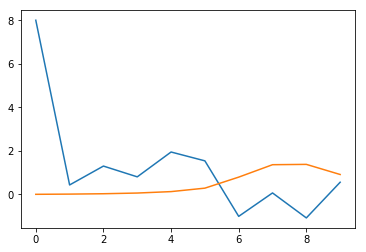

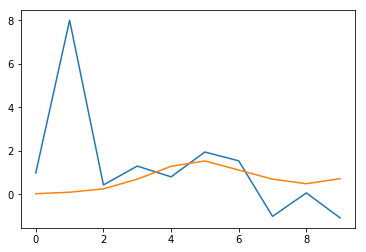

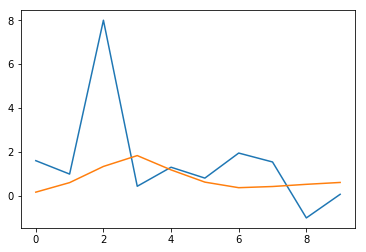

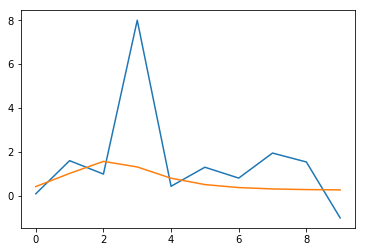

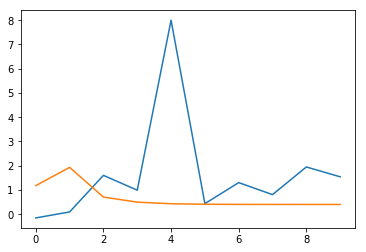

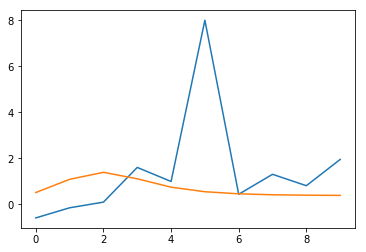

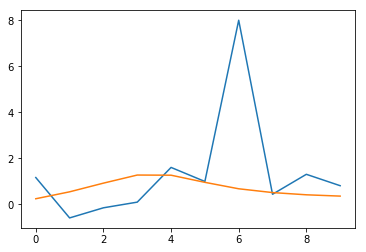

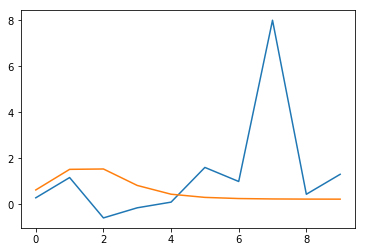

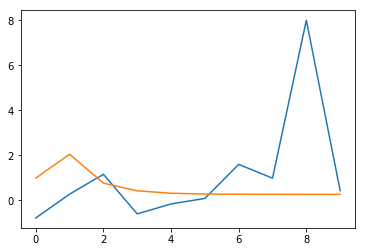

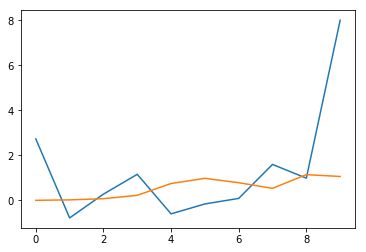

In [20]:
import matplotlib.pyplot as plt
for index in outlier_indices[0:10]:
    plt.plot(x_test_rev[index])
    plt.plot(pred_x_test[index])
    plt.show()